# Data Fundamentals (H)
John H. Williamson -- Session 2020/2021

----

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**



---

## Lab 5: **Assessed**
# Optimisation and gradient descent


### Notes
It is recommended to keep the lecture notes open while doing this lab exercise.

**This exercise is assessed and is marked out of 60**. Make sure you upload your solution by the deadline. See the notes at the bottom of this notebook for submission guidance.

### Guidance
This lab is structured like a worked tutorial, rather than an "open" exercise. Make sure you read the instructions carefully. There is less thinking but more reading required in this exercise than in previous labs.

$$\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\vec{x}\real
$$

## Purpose of this lab
This lab should help you:    
* understand how optimisation can be used to solve approximation problems.
* understand how learning can be seen as an optimisation problem.
* use automatic differentiation to accelerate optimisation.

You will implement a very simple form of **deep learning** in this lab, using first-order optimisation to learn an approximating function.

 If you find the concepts difficult, you might find this video helpful: [**How machines learn**](https://www.youtube.com/watch?v=IHZwWFHWa-w).


## Before you start
You need to install `autograd.` The cell below will autoinstall this for you if the machine you are using does not already have it installed. 

<div class="alert alert-box alert-danger">
    
If autograd installs when your run this cell, you must restart the kernel to correctly import it!
</div>    

In [1]:
try:
    import autograd.numpy as np
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten    
    print("autograd succesfully imported. Everything OK. ")
    # Standard imports    
    
    # custom utils
    from jhwutils.checkarr import array_hash, check_hash
    import jhwutils.image_audio as ia
    import jhwutils.tick as tick
    np.set_printoptions(suppress=True)

    # Set up Matplotlib
    import matplotlib as mpl   
    import matplotlib.pyplot as plt
    %matplotlib inline
    print("Everything imported OK")
    plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
except:
    # couldn't import, install the package
    print("autograd not found.\nInstalling autograd from git...")
    !pip install --no-cache --user git+https://github.com/HIPS/autograd
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    

autograd succesfully imported. Everything OK. 
Everything imported OK


/home/unreal/.local/lib/python3.8/site-packages/IPython/kernel/__init__.py:12: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  warn("The `IPython.kernel` package has been deprecated since IPython 4.0."


# Tutorial: gradient descent

## Background

* An optimisation *problem* has **parameters**, (possibly) **constraints** and an **objective function**.

* An optimisation *algorithm* has **hyperparameters** which determine how the search for the best parameter setting is conducted (for example, how big of a step to take when trying to move down the gradient of a function).

* We will be working with **differentiable** objective functions, where we can compute the gradient of the function at any point, and use this information to quickly move towards the minimum.

### Simple optimisation

Suppose we have a 4D parameter space ($\theta \in \real^4$), and an objective function $$L(\theta) = \sum_i (\theta_i-i)^2$$

We can write this in code:



In [2]:
def l(theta): # objective function
    i = np.arange(len(theta))  # 0, 1, 2, ...
    return np.sum((theta - i) ** 2)  # sum of squares difference

In [3]:
# some random point in a 4D vector space
theta_0 = np.array([0.1, 0.2, 0.3, -0.5])

# compute loss (objective function value) at this point
print(l(theta_0))

15.79


How could we find the value where this objective function has a minimum -- the setting of $\theta$ that minmises $L(\theta)$? The answer is possibly obvious by inspection (it's the vector $[0,1,2,3]$), but assume we didn't already know this.

### Random search: guessing solutions
One solution would be to use purely random search, guessing a random $\theta$ and keeping the best guess so far:

In [4]:
def random_search(l, max_iters, guess_fn):
    best_guess, best_loss = None, None    
    
    for i in range(max_iters):
        # random guess
        guess = guess_fn()
        loss = l(guess) # work out how bad it is
        # check if we beat the record
        if best_loss is None or l(guess)<best_loss:
            best_loss = l(guess)
            best_guess = guess
    return best_guess

# guess a vector between -10 and 10, with 4 elements 
def guess():
    return np.random.uniform(-10, 10, 4) 

np.random.seed(2018)
# try 10 repetitions
for i in range(10):
    result =  random_search(l, 10000, guess)
    print("Best random guess {guess}, loss {loss:.2f}".format(guess=result, loss=l(result)))
    

Best random guess [-0.16918377  1.05119134  2.77061743  2.44545217], loss 0.93
Best random guess [-0.50523686  0.12017663  1.258764    2.53820979], loss 1.79
Best random guess [-0.61103061  0.46247883  2.53234919  2.81458117], loss 0.98
Best random guess [0.30952519 0.65466548 3.06216744 3.81791383], loss 2.01
Best random guess [0.28983761 2.05764936 1.16364807 3.21907244], loss 1.95
Best random guess [0.13515092 0.59394913 2.11399359 3.50123131], loss 0.45
Best random guess [1.09652166 0.88088228 2.27112916 4.193174  ], loss 2.71
Best random guess [-0.04754276  2.17030359  1.34162373  3.19580324], loss 1.84
Best random guess [-0.44193472 -0.51307128  2.14829561  2.79703572], loss 2.55
Best random guess [1.49532531 0.95002838 2.31632764 3.18242229], loss 2.37


### Hill climbing
This does not work very well, and does not ever closely approximate the vector `[0,1,2,3]`. But the space of the objective function is continuous and our objective function might also be continuous. This means we could take advantage of the continuity; a small change in our parameters might lead to a small change in the objective function.

**Task** Write code to do stochastic hill-climbing search, instead of pure random search. Adjust the parameterisation of the search until the tests pass (this should be relatively easy). Note that the test will test against a **random** target; you can't hardcode the solution to just return `[0,1,2,3]`!

In [6]:
def guess():    
    # YOUR CODE HERE
    return np.random.uniform(-10,10,4)

def neighbour(x):    
    # YOUR CODE HERE
    return np.random.uniform(-0.1, 0.1, x.shape) + x
    
def hill_climbing(l, max_iters, guess_fn, neighbour_fn):    
    # YOUR CODE HERE
    best_guess = guess_fn()
    for i in range(max_iters):
        guess = neighbour_fn(best_guess)
        if l(guess) < l(best_guess):
            best_guess = guess
    return best_guess

### Testing hill-climbing
The code below will test your solution. It should be apparent that hill climbing does a much better job, getting to a good solution within 5000 iterations.

You must have defined functions:
    
* `hill_climbing`
* `guess` (returns a random guess)
* `neighbour` (returns a modification of a current estimate for theta)

How you implement and use these is up to you.

The hill climbing optimiser should expect to optimise a 4 element parameter vector.

In [7]:
# try 10 times
with tick.marks(4):
    np.random.seed(2018)
    passed = True
    for i in range(10):
        target = np.random.uniform(0,4,4)
        # use a random target :)
        def custom_l(theta):
            return np.sum((theta-target)**2)          
        # 5000 iterations
        result = hill_climbing(custom_l, 5000, guess, neighbour)
        difference = custom_l(result)               
        print("Loss on run {i} is {loss:.2e}".format(i=i, loss=difference))        
        if difference>0.1:
            passed = False        
    assert(passed)    

Loss on run 0 is 1.14e-04
Loss on run 1 is 1.64e-04
Loss on run 2 is 4.67e-04
Loss on run 3 is 1.31e-04
Loss on run 4 is 2.46e-04
Loss on run 5 is 1.24e-04
Loss on run 6 is 5.08e-04
Loss on run 7 is 9.90e-05
Loss on run 8 is 1.82e-04
Loss on run 9 is 4.81e-04


## Beyond continuity: differentiability 
Having a continuous objective function made it easy to optimise this solution, compared to having to use pure random search. We can do much better, however.

If we can differentiate `l` then we can use **gradient descent** to solve the problem, using the algorithm:

$$\vec{\theta^{(i+1)}} = \vec{\theta^{(i)}} - \delta \nabla L(\vec{\theta^{(i)}})$$

`autograd` makes this trivially easy, and can automatically compute the derivatives of our code:

In [8]:
# compute gradient of l with respect to theta
## IMPORTANT: grad() takes a *function* and returns a function that evaluates the derivative instead
grad_l = grad(l)

In [9]:
# this will be a vector, with as many dimensions has theta
print(grad_l(theta_0))

[ 0.2 -1.6 -3.4 -7. ]


The result is a **vector** which points in the direction where the objective function should be decreasing. We can try moving a small amount in this direction, computing the loss as we go:

In [10]:
theta = np.array(theta_0)
delta = 0.2 # how big of steps to take

for i in range(15):
    theta = theta - delta * grad_l(theta)
    print("Loss:", l(theta))

Loss: 5.684399999999998
Loss: 2.046384
Loss: 0.7366982400000004
Loss: 0.26521136640000026
Loss: 0.095476091904
Loss: 0.03437139308543999
Loss: 0.012373701510758426
Loss: 0.004454532543873043
Loss: 0.0016036317157942864
Loss: 0.0005773074176859468
Loss: 0.0002078306703669451
Loss: 7.481904133210234e-05
Loss: 2.6934854879555166e-05
Loss: 9.696547756639742e-06
Loss: 3.4907571923898273e-06


This quickly reduces the objective function value, and gets very close to the true solution. While hill-climbing took thousands of iterations, and random search never got close to a good solution, this approach finds a very precise solution in only 15 iterations.

In [11]:
print(theta) # should be close to [0,1,2,3]

[0.00004702 0.99962385 1.99920069 2.99835435]


# The moon phase problem
Given an image of the moon, can we predict what phase it is in? For example, the moon image below has a phase of 50 degrees:
<img src="data/m050.gif">

*Phase:50 degrees* 

and this one has a phase of 114 degrees:

<img src="data/m114.gif">

 *Phase:114 degrees* 

How can we use optimisation to solve this problem? We need to have a *parameterisable function* that somehow maps from images to phases, and then adjust the parameters until the function maps moon images onto moon phases. 

That is, we want to find some function $f$ that takes an image as input, and outputs a moon phase as output. $f$ must be configurable with a vector of parameters $\theta$.


#### Approximation
We will be trying to approximate a function. This means we have an objective function of the form:

$$L(\theta) = \|f(\vec{x};\theta)-y\|$$

where we measure the difference between a predicted output $f(\vec{x};\theta)$ and a real, expected output $y$, and try and minimise that difference by choosing a good setting for $\theta$.

We will build a simple "deep learning" system. We will completely ignore many of the important problems in machine learning, like overfitting, regularisation, efficient network architectures and fair evaluation,  and concentrate on using first-order optimisation to find a function that approximates a known transformation.


### Loading the data
There are 181 images of the moon in files `data/moonXXX.gif`, where `XXX` is a three digit number representing the phase of the moon in degrees. Each image is 100x100 pixels, grayscale. The files are in *two degree increments* of the phase of the moon:

    `m000.gif`
    `m002.gif`
    ...
    `m358.gif`
    `m360.gif`

(the [dataset comes from the US Navy](http://tycho.usno.navy.mil/vphase.html))

You can load an image with `ia.load_image_gray()`, as below

(100, 100)


/home/unreal/.local/lib/python3.8/site-packages/jhwutils/image_audio.py:42: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = skimage.color.rgb2gray(skimage.io.imread(fname, plugin="pil"))


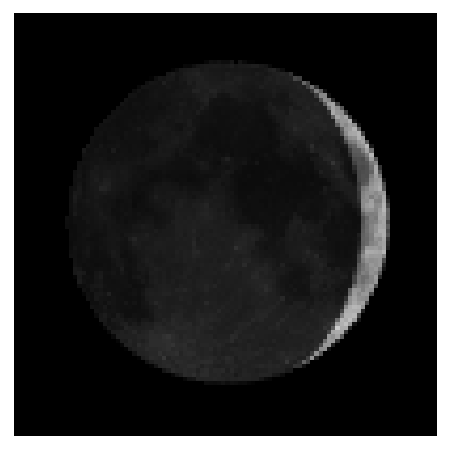

In [12]:
# *must* divide by 255.0 to normalise the result
moon_050 = ia.load_image_gray('data/m050.gif') / 255.0
print(moon_050.shape) # should be 100x100
ia.show_image_mpl(moon_050) # show the image

### Step 1. Load the data
* Load all of the moon data into a single tensor `moon`. 
* **When you load the data, take only every 4th row and every 4th column of each image, to reduce the size of each image to 25x25.**
* `moon` should be a 181x25x25 tensor.
* Make sure that the images are normalised to [0,1] as above. 
* Use a `for` loop to load the data. 


Tip: in Python, you can take an integer `i` and interpolate it into a string with a fixed number of digits like this:

In [13]:
i = 5
fname = f"filename_{i:03d}"
print(fname)

filename_005


In [14]:
# YOUR CODE HERE
moon = np.zeros((181,25,25))
for i in range(0,362,2):
    moon[i//2] = ia.load_image_gray(f"data/m{i:03d}.gif")[::4,::4] / 255.0

In [15]:
with tick.marks(4):
    print(array_hash(moon))
    assert(check_hash(moon, ((181, 25, 25), 949568872.41165507)))

((181, 25, 25), 949568872.4116551)


If you did this correctly, you'll see a low-res moon animation when you run the code below:

In [16]:
ia.show_gif(moon, width="100px")

## Image vectors

We have to be able to write this problem in the form:

$$L(\theta) = \|f(\vec{x};\theta)-\vec{y}\|$$

Every input vector $\vec{x}$ must have a corresponding matched expected output $\vec{y}$, and we need a function $f$ that depends on $\vec{x}$ and $\theta$.

### Inputs
What is $\vec{x}$? How can we define the input to this function? We need to have one vector per example; that is a matrix with one row per moon image. We can do this by reshaping the `moon` tensor to unravel the 25x25 pixel image into a single 625 dimensional vector.

### Step 2
Reshape the moon tensor to a 181x625 matrix; each row being a moon image as a single "unravelled" vector. Store this in `moonputs`.

In [17]:
# YOUR CODE HERE
moonputs = moon.reshape(181,625)

In [18]:
with tick.marks(4):
    print(array_hash(moonputs))
    assert(check_hash(moonputs,((181, 625), 949568872.41165507)))

((181, 625), 949568872.4116551)


### The expected outputs
$\vec{y}$ will be the *known* moon phase for each image. The moon images are taken at two degree increments, so we know that the image `moon[15,:,:]` corresponds to the moon at phase 30 degrees, for example. 


### Remapping y
The neural network we will define will map all predictions to the range [-1,1], so $\vec{y}$ must be scaled to be in this range.  We *could* just take the angle in degrees and rescale it to the range [-1,1] and use this as the $\vec{y}$. However, this is quite a difficult function to learn, because moon phase 0 is the same as moon phase 360; the predicted output would have to wrap around suddenly. This would be discontinuous and hard to predict. Instead, we can map the moon phase to a 2D vector, representing a fixed length vector at a given angle, where the angle corresponds to the moon phase.  This vector will be given by $\vec{y}=[r\cos(a), -r\sin(a)]$, where $r$ is an arbitrary scaling factor and $a$ is the phase angle of the moon. This representation has no discontinuities and will be easy to learn.

### Step 3
With $r=0.5$, generate the `181 x 2` matrix of outputs `expected_outputs`, where each row is $\vec{y}$ as defined above, for each moon phase corresponding to the rows of the `inputs` matrix. Remember that you will need to convert degrees to radians when using `numpy` trigonometric functions.

The image plotted in the test should look like: <img src="imgs/angle.png" width="50%">


In [19]:
# YOUR CODE HERE
r = 0.5
expected_outputs = np.zeros((181,2))
for i in range(181):
    expected_outputs[i][0] = r * np.cos(np.deg2rad(i*2))
    expected_outputs[i][1] = - r * np.sin(np.deg2rad(i*2))


((181, 2), 5246.951478676427)


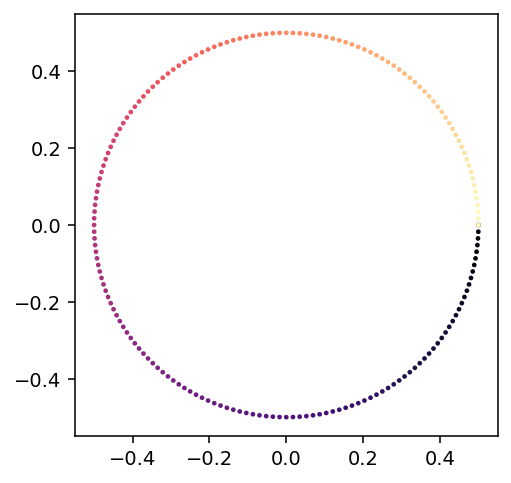

In [20]:
# plot the results
fig, ax = plt.subplots()
ax.scatter(expected_outputs[:,0], expected_outputs[:,1], c=np.arange(181), s=2, cmap='magma')
ax.set_aspect(1.0)

# test that the result is corrected
with tick.marks(4):
    print(array_hash(expected_outputs))
    assert(check_hash(expected_outputs, ((181, 2), 5246.9514786764266)))
    
    

If you have done this correctly, when you run the code below you will see the moons shown in a ring below, new moon on the right, full moon on the left. It should look like the following:

<img src="imgs/moon_phases.png" width="80%">

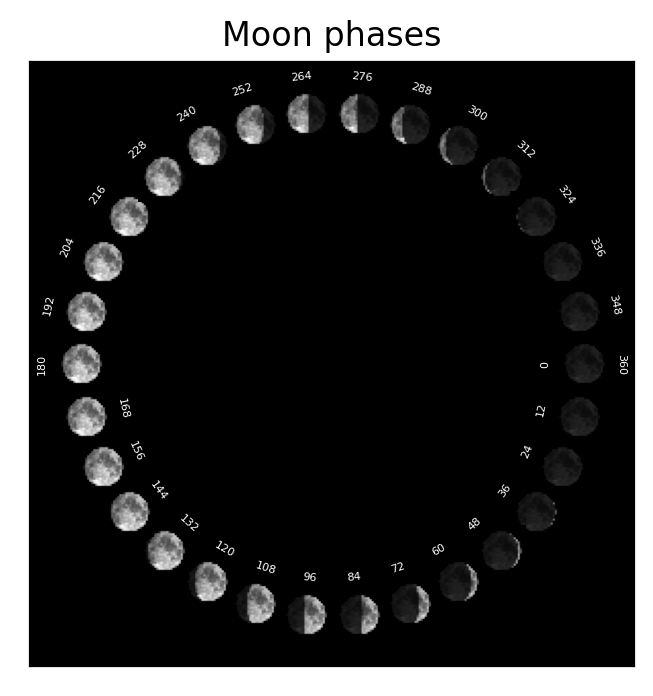

In [21]:
def show_moons(images, positions):
    # show the moons, and their phases
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 0.05
    for i in range(0,len(expected_outputs),6):
        pos = positions[i]
        phase = -np.degrees(np.arctan2(pos[1], pos[0]))
        if phase<0:
            phase += 360
        # show the image at the output position
        ax.imshow(images[i].reshape(moon.shape[1],moon.shape[2]), extent=[pos[0]-sz, pos[0]+sz, pos[1]-sz, pos[1]+sz], vmin=0, vmax=1, cmap='gray')
        # label the phases
        if phase<180:
            ax.text(pos[0]*.85, pos[1]*.85, "%.0f"%(phase), fontsize=4, color='w', rotation=90-phase, ha='center', va='center')
        else:
            ax.text(pos[0]*1.15, pos[1]*1.15, "%.0f"%(phase), fontsize=4, color='w', rotation=90-phase+180, ha='center', va='center')

    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Moon phases")
    
# apply to the *known* inputs and outputs; will be a perfect circle    
show_moons(moonputs, expected_outputs)


## A deep network
How will this parameterisable function that maps from images to phases be defined? We will use a very simple deep "neural network" predictor. This is an incredibly simple algorithm. It takes a vector, then repeatedly:

* adds a small constant
* takes the `tanh()` of the resulting vector; this simply squashes all the elements of the vector so they lie in the range [-1,1]
* multiplies the vector by a (different) matrix

We have to define the *shape* of each of the matrices which will be used to transform the vector, but we *optimise* to find the elements that go into those matrices. This is the "learning" part.

Each of these steps is traditionally called a "layer" of the prediction function.

In [22]:
# a very basic neural network
# the only slightly subtle thing is the unflattening, which is explained below
def predict(x, theta, unflatten):        
    for w in unflatten(theta):          
        x = w.T @ np.tanh(x + 0.1)
    return x

### Flattening and unflattening
<div class="alert alert-box alert-danger"> 
    
**READ THIS SECTION CAREFULLY**

</div>

To be able to optimise this prediction function in the standard form, we have to package *all* of the things that could vary into a single "flat" parameter vector $\theta$. `predict()` can unpack a list of matrices from a single vector if it is given the right `unflatten` parameter. We can use the `flatten` convenience function to make this easy; this is provided by **autograd**.

    theta, unflatten = flatten(list_of_matrices)

takes a list of matrices `list_of_matrices` and returns them packed into a single 1D NumPy vector `theta` along with `unflatten`, a function which will reverse that process and unpack all the matrices when applied to `theta`.

`flatten` is like a "super-ravel" which can be reversed by the `unflatten` function which it returns. Note: `unflatten` is not in any way "attached" to the data. It is simply a function which knows how to unpack a list of matrices of certain shapes from a single parameter vector.

See the examples below:

In [23]:
# create a list of matrices
list_of_matrices = [np.zeros((3, 3)), np.ones((2, 4)), np.full((1, 4), 2.0)]
print(list_of_matrices)

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


In [24]:
# convert to a flat vector
# along with a *function* which will later unflatten theta back into a list of matrices
theta, unflatten = flatten(list_of_matrices)

In [25]:
# the flattened version; a single vector
print(theta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]


In [26]:
# restore the flattened version to original shapes
print(unflatten(theta))

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


### Objective function

**Task B.4**

Write an objective function that will compare the predicted output to the expected output, for one set of input and output vectors, given `theta`, `unflatten`, `x` and `y`. Use the $L_2$ norm. The function should be of the form

    def face_loss(theta, unflatten, x, y):
        ...
        return l # a scalar
        
The loss function will need to call `predict` to calculate `y_prime`, the predicted output to compare with `y`. Assume `x` and `y` are vectors. 

In [27]:
def loss(theta, unflatten, x, y):
    y_prime = predict(x, theta, unflatten)
    loss = y_prime - y
    loss = np.linalg.norm(loss, ord=2)
    return loss

In [28]:
# create a random set of weights, and test that the loss function is computed correctly
test_network = [
    np.array([[1, 0.5, -0.5], [0.0, 2.0, -1.0]]).T,
    np.array([[2.0, 1.0], [1.0, -1.0]]).T,
]

theta, unflatten = flatten(test_network)

with tick.marks(4):
    assert (
        abs(loss(theta, unflatten, np.array([1, 2, 3]), np.array([-1, 1])) - 3.37) < 0.2
    )

### Network architecture
The choice of the matrix shapes we use to do the prediction affects how well we will be able to model the transformation. In our example, we know we have 625 dimensional inputs (25x25 moon images unraveled into flat vectors) and 2 dimensional outputs (the oriented vectors we generated above). So the we must start with 625 dimensional vectors and end up with 2 dimensional vectors. However, we can introduce any number of intermediate matrices into the prediction function. This gives more parameters that could be tweaked, and more flexibility in how the mapping is learned; it makes the prediction function more *flexible*.

A very simple model might have a single 625,2 matrix; this would be a simple linear transformation of the inputs.

    W[0]
    625, 2

A more complex model might have a mapping with:

    W[0]     W[1]      W[2]   W[3]
    625,32 -> 32,16 -> 16,8 -> 8,2

This "architecture" maps the 400 dimensional input vector to some 32 dimensional space, then to some 16 dimensional space, then to some 8 dimensional space, then to the 2 dimensional output. Every matrix has to have an output dimension which matches the input dimension of the following matrix. The matrices W[0], W[1], W[2], W[3]  specify how the vector at each layer gets mapped to the next layer. All of these matrices `W[i]` are flattened into a single vector `theta` for optimisation -- this is just a reshaping of their elements.


We *don't know* what values should go into these matrices; they specify some unknown transformation of the vectors in each step. We have to optimise to find the elements of these matrices.

                 W[0]   W[1]   W[2]  W[3] 
    (input) 625D -> 32D -> 16D -> 8D -> 2D  (output)

The choices of these matrix shapes are not hugely important (I just made the ones above up); but more matrices with more elements means a more flexible function which can learn more complicated things; but will be harder to optimise efficiently.

For this lab, assume that the matrix shapes to be used are:

    625,32  32,16  16,8  8,2

This will work well, without being too hard to optimise. You can alter this if you want, but the above version is known to work.

### Task: initialisation
We need to set up some *initial conditions* for the optimisation process. We can define the shape of each matrix, but we don't know what the values of the elements in the matrices should be, because we will find this by optimisation. So we just make a random guess.

* Create a function that generates initial conditions for the prediction function. 
* This function should take a list of matrix *shapes*, and create a corresponding list of randomly filled matrices.  
* Each matrix generated should have the specified shape.  
* The function should take a parameter `sigma` that should specify the spread of the random values chosen.

Use `np.random.normal(0, sigma, shape)` to generate the random numbers.

Return the **flattened** version of the matrix list, along with the corresponding `unflatten` function.

Your function should have the form:
    
    def initial_conditions(shape_list, sigma):
        ...
        return theta, unflatten        

For example `initial_conditions([[2,3], [3,6]], 0.1)` should return the flattened version of a `(2,3)` and `(3,6)` shape random matrices.

In [29]:
def initial_conditions(shape_list, sigma):    
    out = []
    for shape in shape_list:
        out.append(np.random.normal(0, sigma, shape))
    return flatten(out)

In [30]:
theta, unflatten = initial_conditions([[8,4], [4,8], [2,4]], 0.1)
matrices = unflatten(theta)
with tick.marks(4):
    assert(matrices[0].shape==(8,4))
    assert(matrices[1].shape==(4,8))
    assert(matrices[2].shape==(2,4))

## Random predictions
We can use predict to see the effect of applying this function to the moon images. Since all of the matrices are random, the result will be a random mess.

Text(0.5, 1.0, 'Random moon phases')

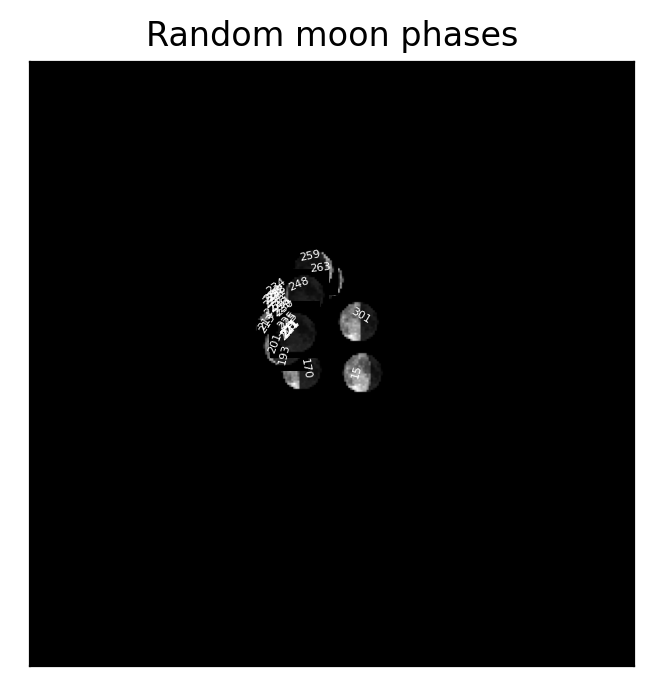

In [31]:
# create some test initial conditions
random_theta, unflatten = initial_conditions( [[625,32], [32, 16],  [16, 8], [8,2]], 0.2)
# predict the outputs (will be random junk)
predicted_outputs = [predict(moonputs[i], random_theta, unflatten) for i in range(181)]
show_moons(moonputs, np.array(predicted_outputs))
plt.gca().set_title("Random moon phases")

**Task** Write a function `total_moon_loss` that computes the sum of the objective function value for *every* matched input and output pair from `moonputs` and `expected_outputs`.  That is, it computes:

$$L(\theta) = \sum_i \|y'_i - f(\vec{x_i};\theta)\|$$

where $x_i$ is the ith row of `moonputs`, $y_i$ is the ith row of `expected_outputs` and `theta` is the parameter vector. The function must also take an `unflatten` argument so it can unpack the parameter vector correctly. **This function should use the `loss` function you defined above**

In [32]:
# compute the sum of losses
# for every pair of xs and ys
def total_moon_loss(theta, unflatten):
    total_loss = 0
    for i in range(len(moonputs)):
        total_loss += loss(theta, unflatten, moonputs[i], expected_outputs[i])
    return total_loss
    

In [33]:
np.random.seed(2018)

# create some test initial conditions
random_theta, random_unflatten = flatten([np.random.normal(0,1,(625,4)), np.random.normal(0,1,(4,2))])

with tick.marks(2):    
    assert(np.allclose(total_moon_loss(random_theta, random_unflatten), 244.98878306938445, atol=1e-1))

## Hill-climbing search
    
You now have enough to build a very basic optimiser. 

**Task** Implement hill-climbing search to find a set of parameters that produces a better layout than the above version. Note that you will need to return both your optimised `theta` and the `unflatten` required to shape it back into a sequence of matrices (unflatten is passed through the optimiser unchanged). Use matrix shapes `[[625,32], [32, 16],  [16, 8], [8,2]]`

You already have `initial_conditions` that will produce an initial guess. Write a function to adjust the parameter vector by a small random variation. Then adapt your hill climbing code from earlier to try and optimise the mapping of moon images to moon positions. Use `total_moon_loss` to compute the objective function summed over every image example.


In [34]:

def hill_climbing(l, max_iters, guess_fn, neighbour_fn):    
    theta, unflatten = guess_fn()
    best_guess = theta
    for i in range(max_iters):
        guess = neighbour_fn(best_guess)
        if l(guess, unflatten) < l(best_guess, unflatten):
            best_guess = guess
    return best_guess, unflatten

# create some test initial conditions
def moon_guess():
    return initial_conditions([[625,32], [32,16], [16,8], [8,2]], 0.1)
    
def moon_neighbour(x):
    return np.random.uniform(-0.05, 0.05, x.shape) + x

    

Loss in prediction 30.026636126772527


Text(0.5, 1.0, 'Hill climbed face orientation predictions')

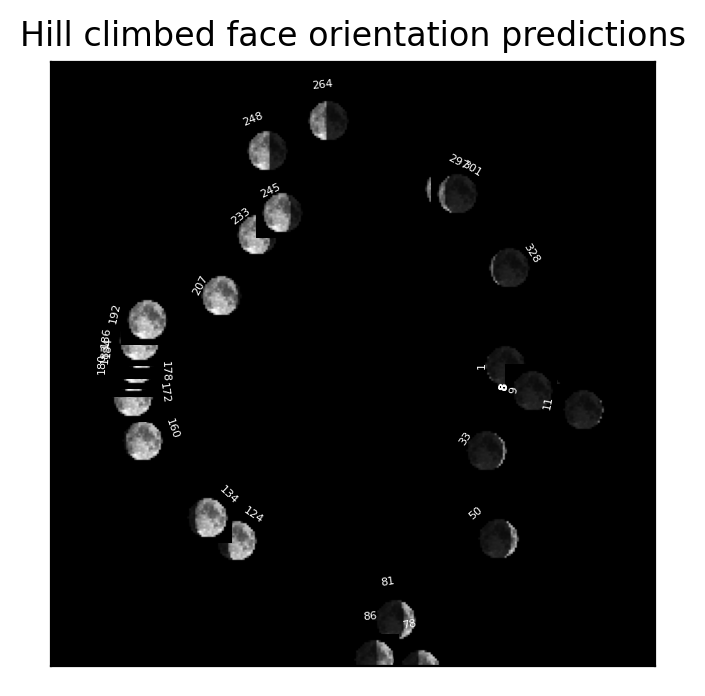

In [35]:
np.random.seed(2018)

# you will need to define face_guess and face_neighbour
result,  unflatten = hill_climbing(total_moon_loss, 250, moon_guess, moon_neighbour)

print("Loss in prediction {loss}".format(loss=total_moon_loss(result, unflatten)))

with tick.marks(4):
    assert(total_moon_loss(result, unflatten)<60)
    
# prediction should be slightly better than random
predicted_outputs = [predict(moonputs[i], result, unflatten) for i in range(181)]
show_moons(moonputs, np.array(predicted_outputs))
plt.gca().set_title("Hill climbed face orientation predictions")

## Gradient descent learning

Hill climbing gives some kind of result, but it is not very satisfactory -- although it is still quite impressive that we can learn an approximate face orientation predictor by randomly twiddling some values in a collection of matrices.

Now we will optimise with gradient descent, and get a much better result.  In this task, you will have to define a function `sgd_learn`. This will perform a simple form of (stochastic) gradient descent.

## Differentiation

Using automatic differentiation provided by `autograd`, compute the derivative of the loss function `loss` (the loss function for *one* single example you defined above), and call it `grad_moon_loss`. Hint: this is trivial.

In [36]:
# YOUR CODE HERE
grad_moon_loss = grad(loss)

In [37]:
np.random.seed(2018)

# create some test initial conditions
random_theta, random_unflatten = flatten(
    [np.random.normal(0, 1, (625, 4)), np.random.normal(0, 1, (4, 2))]
)

with tick.marks(4):
    assert np.allclose(np.sum(grad_moon_loss(random_theta, random_unflatten,
                              moonputs[0], expected_outputs[0]
                             )), 54.01365427573643, atol=1e-1)
        

**Task** 

Now define a function to perform stocahstic gradient descent.

`sgd_learn(shapes, inputs, outputs, sigma, step, iters)` should:

* take a list of matrix `shapes`, a `sigma` to specify the random initialisation of those matrices, a `step` size and a number of `iterations`
* generate an initial `theta` from that set of shapes, using the `initial_condition()` function you defined above.
* for each of the given number of iterations
    * randomly select *ONE* input vector (from `inputs`) and matching output vector (from `outputs`).
    * compute the gradient of the objective function for that image/output pair
    * make a step, adjusting `theta` in the direction of this gradient, scaled by the step size
    * print the iteration count every 500 iterations so you can see that the function is running
correctly. 

* return the flattened vector and the corresponding unflatten function

The function definition should look like:

        def sgd_learn(shapes, inputs, outputs, sigma, step, iters):
            ...        
            return theta, unflatten

Note: You don't need to implement *any* sophistications like momentum or random restart. You don't need to collect the data into minibatches. The algorithm you implement should be very simple. 

* You may also want to evaluate the objective function itself at each iteration, and print out the sum of the objective function value overs the last 100 iterations in your print statement (this is optional, but helps in tuning the performance; the number should go down as optimisation progresses).

In [38]:
def sgd_learn(shapes, inputs, outputs, sigma=0.1, step=0.1, iters=10000):
    theta, unflatten = initial_conditions(shapes, sigma)
    for i in range(1,iters+1):
        choice = np.random.choice(181)
        rand_in = inputs[choice]
        rand_out = outputs[choice]
        gradient = grad_moon_loss(theta, unflatten,rand_in, rand_out)
        if np.all(gradient == 0):
            theta += step * gradient
        else:
            theta -= step * gradient
        if i % 500 == 0 :
            print(i)
    w = theta    
    return w, unflatten

In [39]:
# verify that the shapes come out right
with tick.marks(2):
    test_theta, test_unflatten = sgd_learn([[625,2]], moonputs, expected_outputs, 0.1, 0.1, 1)
    unflattened = test_unflatten(test_theta)
    assert(len(unflattened)==1)
    assert((unflattened[0].shape)==(625,2))


In [40]:
## verify that some learning happens
with tick.marks(4):
    np.random.seed(2019)
    test_theta, test_unflatten = sgd_learn([[625,2]], moonputs, expected_outputs, sigma=0.5, step=0.01, iters=0)
    before_losses = [loss(test_theta, test_unflatten, x,y) for x,y in zip(moonputs, expected_outputs)]
    
    test_theta, test_unflatten = sgd_learn([[625,2]], moonputs, expected_outputs, sigma=0.5, step=0.01, iters=500)
    after_losses = [loss(test_theta, test_unflatten, x,y) for x,y in zip(moonputs, expected_outputs)]
    print("Mean loss before optimising %.2f; after optimising %.2f" % (np.mean(before_losses),  np.mean(after_losses)))
    assert(np.mean(after_losses)/np.mean(before_losses)<0.5)
    print("Something was learned!")
    

500
Mean loss before optimising 2.77; after optimising 0.53
Something was learned!


**Task**

Use this function to learn an approximate mapping from moon images to 2D vectors. You will have to choose:

* a **step size** (values in the range 0.1 to 0.0001 are reasonable)
* the **sigma** for the initial conditions (values in the range 0.5 to 0.005 are reasonable).

These are **hyperparameters** of the optimisation process. 

* You should use *no more* than 20000 iterations in the learning process. 

**Warning: if your call to `sgd_learn` takes more than ten minutes to run, the autograder will not accept your result!**

Use matrix shapes `[[625,32], [32, 16],  [16, 8], [8,2]]`, *or* choose your own set of matrix shapes (just don't make them so large the optimisation takes forever).


In [49]:
## Run sgd_learn(...) in this cell
## produce the output theta, unflatten
## theta, unflatten = learn(...
## LEAVE THIS HERE TO FORCE CONSISTENT RESULTS!
np.random.seed(2019)

theta, unflatten = sgd_learn([[625,32],[32,16],[16,8],[8,2]],moonputs, expected_outputs , 0.3, 0.01, 20000)
print("Done")

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
Done


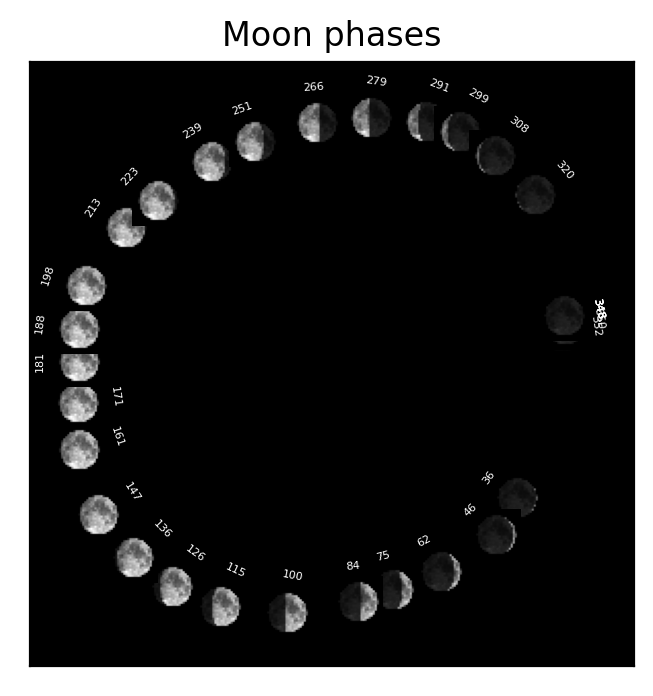

In [42]:
# if your code worked, then it should be able to predict
# what phase the moon is, from the image of the moon
predicted_outputs = [predict(moonputs[i], theta, unflatten) for i in range(181)]
show_moons(moonputs, np.array(predicted_outputs))

In [51]:
predictions = np.array([predict(moonputs[i], theta, unflatten) for i in range(181)])
mse_error = np.sqrt(np.mean((predictions - expected_outputs) ** 2))
print("Total mean squared prediction error: {error:4f}".format(error=mse_error))

Total mean squared prediction error: 0.053259


In [52]:
# you get more marks for a more correct answer :)
with tick.marks(8):
    assert mse_error < 0.5

In [53]:
with tick.marks(6):
    assert mse_error < 0.15

In [54]:
with tick.marks(4):
    assert mse_error < 0.08

In [55]:
with tick.marks(2):
    assert mse_error < 0.05

AssertionError: 

----

If you've got this far, you've managed to build a system which can predict the phase of the moon from a picture of the moon. All that was needed was some simple gradient descent, which optimised a function parameterised with a 20656 dimensional vector (the number of elements in `theta`).

This is not a perfect solution. It is not robust to noise, or to variations in the moon position, scale or rotation. We have no idea if it generalises well to other images of the moon than those we trained on. The mapping we used is extremely wasteful, and ignored the fact that pixels which are close together are probably related. All of these things would be fixed in a real deep learning approach, but the the principle remains the same. We create a parameterisable function, then optimise its parameters to align the approximation with some known training examples.

<div class="alert alert-box alert-success">

# End of assessed portion


</div>

# Extra material
If you really want to understand what is going on in learning in deep networks, read [colah's blog](http://colah.github.io/posts/2015-08-Backprop/),  another [colah article](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/), and [Nielsen's free book](http://neuralnetworksanddeeplearning.com/), or [Deep learning from scratch](http://www.deepideas.net/deep-learning-from-scratch-i-computational-graphs/). You don't need to know **any** of this for this lab though!

### A moon synthesizer: creating images of the moon
We have learned a mapping from moon images to moon phases. We can equally well go the other way; from moon phases to moon images. We built a moon phase recogniser. We can also build a moon phase image *synthesizer*, that will take a 2D vector and predict a moon image. Implement this. This is a *trivial* modification of what has already been implemented; but you will need a different set of matrix shapes to map from 2D up to a 625D vector. Check that you can map from a vector like `[-0.5, 0]` to a 25x25 moon image. Call the return values `syn_theta` and `syn_unflatten`:

In [ ]:
# YOUR CODE HERE

In [ ]:
# test that we can map from a 2 element vector back to a 25x25 element image
img = predict(np.array([-0.5, 0]), syn_theta, syn_unflatten)
ia.show_image_mpl(img.reshape((25,25)))

In [ ]:
# show the results as a circular moon plot
# the images here will be synthesized by the network
# they will not use the original image data!
predicted_inputs = [predict(pos, syn_theta, syn_unflatten) for pos in expected_outputs]
show_moons(predicted_inputs, expected_outputs)

## Advanced: A moon autoencoder
It is possible to learn a mapping from images to 2D positions *without* training the network with known moon phases. In other words, find a mapping from images to some 2D "moon phase" just by looking at the images alone -- a problem of *unsupervised learning*. This can be done with an **autoencoder**; where the function learns a compressive mapping of the inputs through a **bottleneck layer** back to a (noisy) reconstruction of the original inputs. You can do this using a set of matrices which goes from 625 dimensions down through a number of transformations to 2 dimensions, then back up to 625 dimensions, and setting the loss to be the difference *between the input and the predicted input*.

For example:

                                   
    (input) 625D -> 100D -> 20D -> 2D ->  20D -> 100D -> 625D (reconstructed input)
                                   ^ bottleneck layer

Then, you can predict what happens in the "middle" of the transformation where the projection has been forced down to 2D. This is a 2D "explanation" of the data, and will hopefully capture the phase of the moon somehow. If you attempt this, you will need to read up on autoencoders before you will be able to make progress. The function below is very useful for partially evaluating a network:

In [ ]:
def partial_predict(x, theta, unflatten, from_to):
    # evaluate from layer from_to[0] to from_to[1]
    for w in unflatten(theta)[from_to[0]:from_to[1]]:  
        x = w.T @ np.tanh(x + 0.1)
    return x

In [ ]:
# YOUR CODE HERE

In [ ]:
# assumes you called the results auto_theta, auto_unflatten
posns = [partial_predict(x, auto_theta, auto_unflatten, (0,2)) for x in moonputs]
poses = np.array(posns)
poses = posns - np.mean(poses, axis=0)
show_moons(moonputs, poses/3)

This image was generated from the face data without providing any information on the expected output  face orientations. The orientations have a random offset (about 240 degrees), but consistently recover the variation in the face orientation.

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK





<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Plagiarism will be subject to the Plagiarism Policy. The penalties are severe.